In [1]:
import torch

In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
!pip install torch_geometric

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [7]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [9]:
G = to_networkx(data, to_undirected=True)

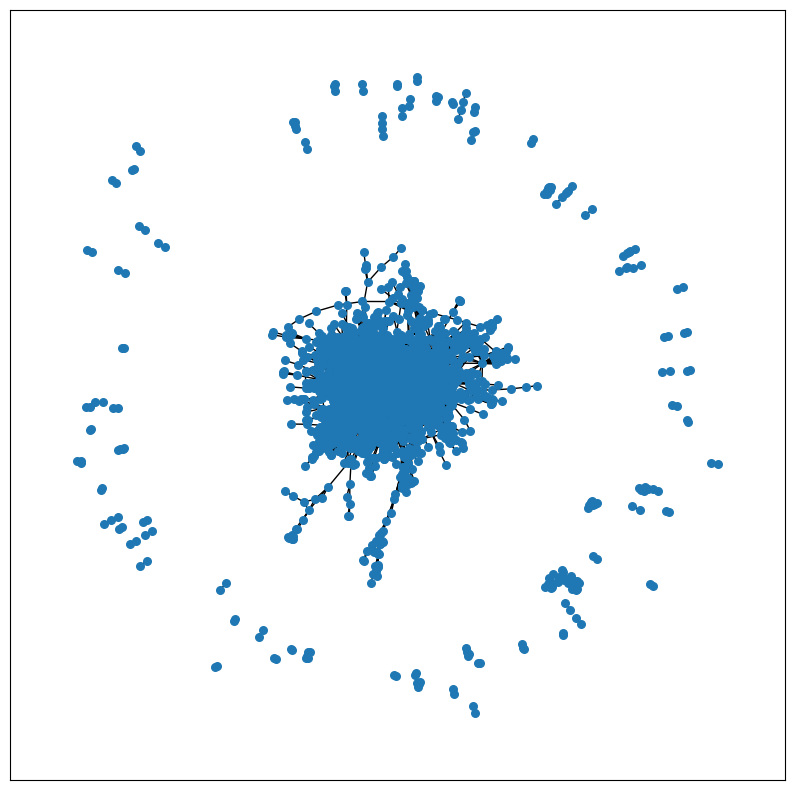

In [10]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=False, node_size=30)
plt.show()

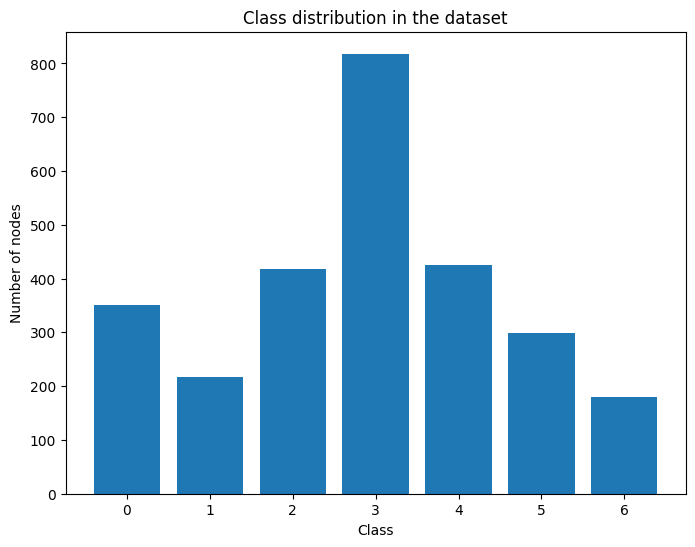

In [11]:
class_counts = torch.bincount(data.y)

plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts)), class_counts.numpy())
plt.xlabel('Class')
plt.ylabel('Number of nodes')
plt.title('Class distribution in the dataset')
plt.show()

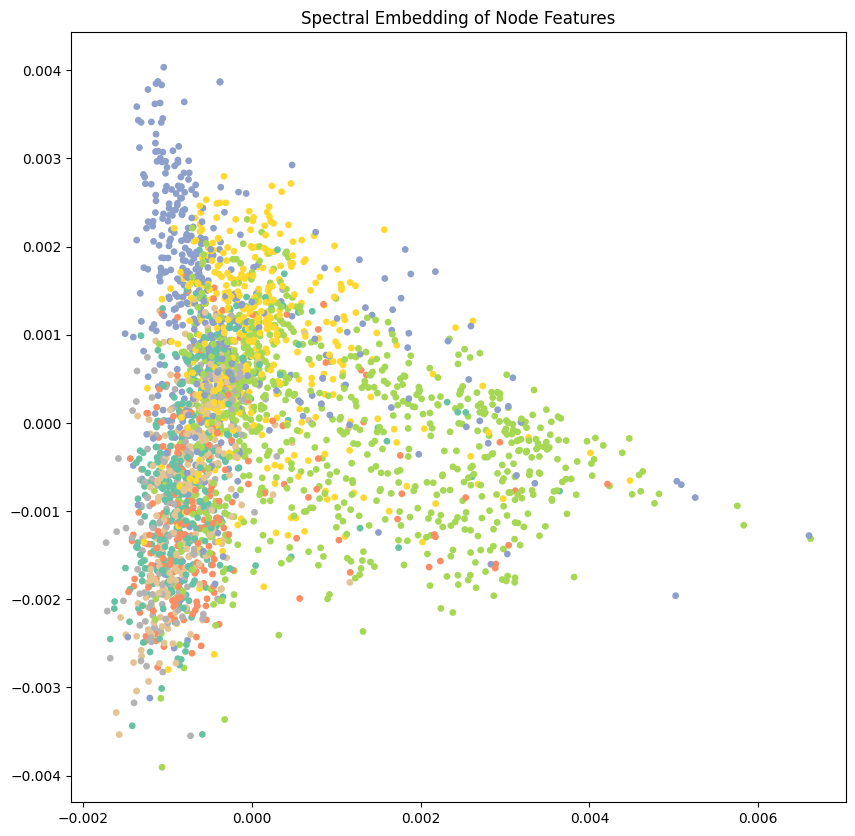

In [12]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2)
z = embedding.fit_transform(data.x.numpy())

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=data.y.numpy(), cmap='Set2', s=15)
plt.title("Spectral Embedding of Node Features")
plt.show()

In [13]:
clustering = nx.clustering(G)
clustering_coeffs = torch.tensor([clustering[i] for i in range(data.num_nodes)]).view(-1, 1)
#data.x = torch.cat([data.x, clustering_coeffs], dim=1)
clustering_coeffs

tensor([[0.3333],
        [0.0000],
        [0.0000],
        ...,
        [0.0000],
        [0.5000],
        [0.8333]])

In [14]:
from torch_geometric.utils import degree

deg = degree(data.edge_index[0], data.num_nodes)
deg

tensor([3., 3., 5.,  ..., 1., 4., 4.])

In [15]:
dataset.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Data object: {data}')
print(f'Edge index shape: {data.edge_index.shape}')
print(f'Node feature shape: {data.x.shape}')

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data object: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Edge index shape: torch.Size([2, 10556])
Node feature shape: torch.Size([2708, 1433])


In [17]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, int(hidden_channels/2))
        self.linear = nn.Linear(int(hidden_channels/2), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 717, dataset.num_classes).to(device)
print(model)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

GCN(
  (conv1): GCNConv(1433, 717)
  (conv2): GCNConv(717, 358)
  (linear): Linear(in_features=358, out_features=7, bias=True)
)


In [20]:
def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [21]:
def validate(model):
    model.eval()
    with torch.no_grad():
      out = model(data.x, data.edge_index)
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
    pred = out.argmax(dim=1)
    embeddings = out.cpu().detach()
    accs = []
    for mask in [data.train_mask, data.val_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return val_loss, accs, embeddings

In [22]:
def test(model):
  model.eval()
  with torch.no_grad():
      out = model(data.x, data.edge_index)
      test_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask]).item()
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
      test_acc = test_correct / data.test_mask.sum().item()
  return test_loss, test_acc

In [23]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [24]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [25]:
data.y[1]

tensor(4)

In [26]:
epochs = 5000
model_save_freq = 1000
print_stats_freq = 50

embeddings_over_time = []

train_loss_over_time = []
val_loss_over_time = []
train_acc_over_time = []
val_acc_over_time = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 717, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, epochs + 1):
    train_loss = train(model)
    val_loss, acc, embeddings = validate(model)
    #embeddings_over_time.append(embeddings)
    train_acc, val_acc = acc
    train_loss_over_time.append(train_loss)
    val_loss_over_time.append(val_loss)
    train_acc_over_time.append(train_acc)
    val_acc_over_time.append(val_acc)
    if epoch % print_stats_freq == 0:
        print(f'Epoch: {epoch:03d}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    if epoch % model_save_freq == 0:
        print(f'Saving model at epoch {epoch}')
        torch.save(model, f'./model_{epoch}.pth')

test_loss, test_acc = test(model)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 050, Train Loss: 0.0324, Train Acc: 1.0000, Val Loss: 0.6766, Val Acc: 0.7920
Epoch: 100, Train Loss: 0.0282, Train Acc: 1.0000, Val Loss: 0.7148, Val Acc: 0.7800
Epoch: 150, Train Loss: 0.0210, Train Acc: 1.0000, Val Loss: 0.6922, Val Acc: 0.7880
Epoch: 200, Train Loss: 0.0193, Train Acc: 1.0000, Val Loss: 0.6855, Val Acc: 0.7760
Epoch: 250, Train Loss: 0.0200, Train Acc: 1.0000, Val Loss: 0.7204, Val Acc: 0.7860
Epoch: 300, Train Loss: 0.0218, Train Acc: 1.0000, Val Loss: 0.7240, Val Acc: 0.7820
Epoch: 350, Train Loss: 0.0236, Train Acc: 1.0000, Val Loss: 0.7517, Val Acc: 0.7640
Epoch: 400, Train Loss: 0.0218, Train Acc: 1.0000, Val Loss: 0.7080, Val Acc: 0.7740
Epoch: 450, Train Loss: 0.0104, Train Acc: 1.0000, Val Loss: 0.8892, Val Acc: 0.7820
Epoch: 500, Train Loss: 0.0232, Train Acc: 1.0000, Val Loss: 0.6821, Val Acc: 0.7800
Epoch: 550, Train Loss: 0.0235, Train Acc: 1.0000, Val Loss: 0.7062, Val Acc: 0.7840
Epoch: 600, Train Loss: 0.0213, Train Acc: 1.0000, Val Loss: 0.68

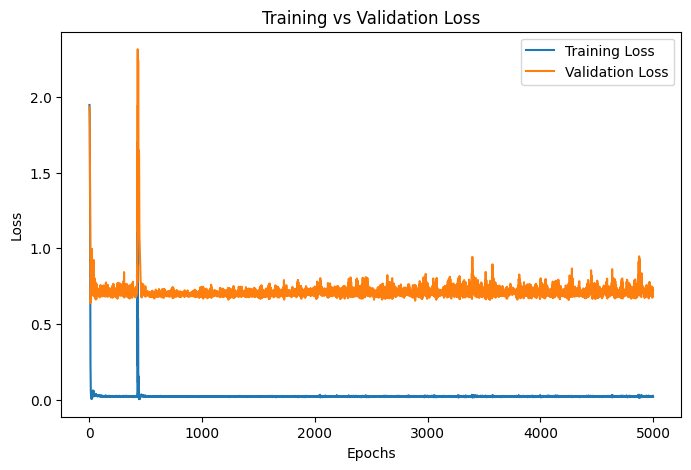

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_over_time, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_over_time, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

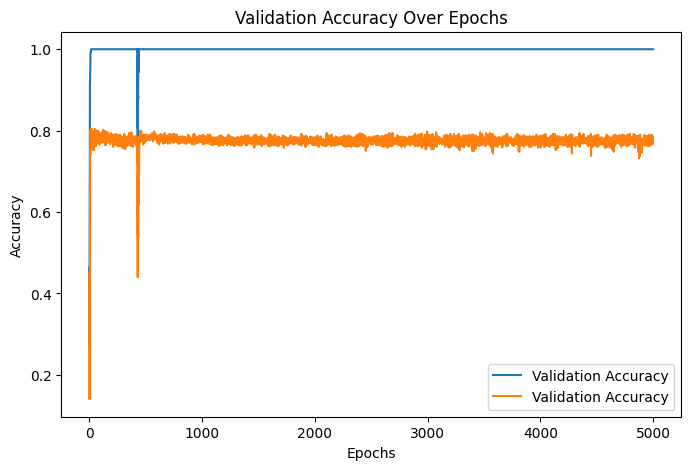

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_acc_over_time, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), val_acc_over_time, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [29]:
model_load = torch.load('./model_5000.pth', weights_only=False)
model_load

GCN(
  (conv1): GCNConv(1433, 717)
  (conv2): GCNConv(717, 358)
  (linear): Linear(in_features=358, out_features=7, bias=True)
)

In [30]:
test(model_load)

(0.7009519934654236, 0.778)